In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
import multielec_src.old_labview_data_reader as oldlv
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl
from gsort.gsort_core_scripts import *
from gsort.gsort_data_loader import *
from itertools import product
import jax
import jax.numpy as jnp
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-0"
wnoise = "kilosort_data000/data000"
blanked_probs = 12
prob_low = 0.12
min_inds = 0
ms = [1]

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([-Ivals[:num_movies].reshape(-1, 1)] * len(trials_neg))

gsorted_cells = parameters['gsorted_cells'].flatten()

In [4]:
vcd = vl.load_vision_data(os.path.join(ANALYSIS_BASE, dataset, wnoise), wnoise.split('/')[-1],
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

In [5]:
gsorted_cells_new = []
for i in range(len(gsorted_cells)):
    if 'parasol' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])
    # if 'midget' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
    #     gsorted_cells_new.append(gsorted_cells[i])

gsorted_cells = np.array(gsorted_cells_new)

In [6]:
# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = 0
all_sigmoids = np.zeros((len(gsorted_cells), all_probs_neg.shape[1], all_probs_neg.shape[2]))

jac_dict = collections.defaultdict(dict)
transform_mat = []
probs_vec = []
num_params = 0

for k in range(len(gsorted_cells)):
    i = gsorted_cells[k]
    for j in range(len(all_probs_neg[i])):
        clean_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
        probs = deepcopy(all_probs_neg[i][j][clean_inds])
        X = deepcopy(amps_neg[j][clean_inds])
        T = trials_neg[j][clean_inds]

        if np.amax(probs) <= prob_low:
            all_sigmoids[k][j] = np.zeros(len(all_sigmoids[k][j]))

        else:
            X, probs, T = fitting.get_monotone_probs_and_amps(X, probs, T)

            if np.count_nonzero(probs > prob_low) < min_inds:
                all_sigmoids[k][j] = np.full(len(all_sigmoids[k][j]), np.nan)
            
            else:
                w_inits = []

                for m in ms:
                    w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
                    w_inits.append(w_init)

                params, _, R2 = fitting.fit_surface(X, probs, T, w_inits)

                all_sigmoids[k][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_neg[j], has_constant='add'), 
                                        params)
                
                X = jnp.array(sm.add_constant(amps_neg[j], has_constant='add'))
                jac_dict[i][j] = jax.jacfwd(fitting.activation_probs, argnums=1)(X, jnp.array(params)).reshape(
                                                (len(X), params.shape[0]*params.shape[1]))
                num_params += jac_dict[i][j].shape[1]

                transform = jnp.zeros(len(trials_neg))
                transform = transform.at[j].set(1)
                transform_mat.append(transform)     # append a e-vector (512)

                probs_vec.append(all_sigmoids[k][j])  # append a c-vector (80)

                # print(cells[i], j+1)
                # print(params, R2)
            
                # plt.figure(0)
                # plt.xlim(-4.2, 0.1)
                # plt.ylim(-0.1, 1.1)
                # plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
                # plt.plot(amps_neg[j].flatten(), all_sigmoids[k][j])
                # plt.show()

                # plt.figure(1)
                # plt.scatter(np.arange(len(amps_neg[j])), all_probs_neg[i][j])
                # plt.show()
                # input()

transform_mat = jnp.array(transform_mat, dtype='float32')
probs_vec = jnp.array(jnp.hstack(probs_vec), dtype='float32')

jac_full = jnp.zeros((len(probs_vec), num_params))
counter_axis0 = 0
counter_axis1 = 0
for i in jac_dict.keys():
    for j in jac_dict[i].keys():
        next_jac = jac_dict[i][j]

        jac_full = jac_full.at[counter_axis0:counter_axis0+next_jac.shape[0], counter_axis1:counter_axis1+next_jac.shape[1]].set(next_jac)

        counter_axis0 += next_jac.shape[0]
        counter_axis1 += next_jac.shape[1]

jac_full = jnp.array(jac_full, dtype='float32')

In [7]:
p_model = jnp.clip(probs_vec, a_min=1e-5, a_max=1-1e-5) # need to clip these to prevent
                                                            # overflow errors
t = jnp.dot(transform_mat, trials_neg).flatten()
I_p = t / (p_model * (1 - p_model))

# Avoiding creating the large diagonal matrix and storing in memory
I_w = jnp.dot((jac_full.T * I_p), jac_full) / len(p_model)

# Avoiding multiplying the matrices out and calculating the trace explicitly
sum_probs = jnp.sum(jnp.multiply(jac_full.T, jnp.linalg.solve(I_w, jac_full.T)), axis=0)
var_vec = np.array((transform_mat.T @ jnp.reshape(sum_probs, (-1, trials_neg.shape[1]))).flatten())

Text(0, 0.5, 'Total Variance of Element (summed across cells)')

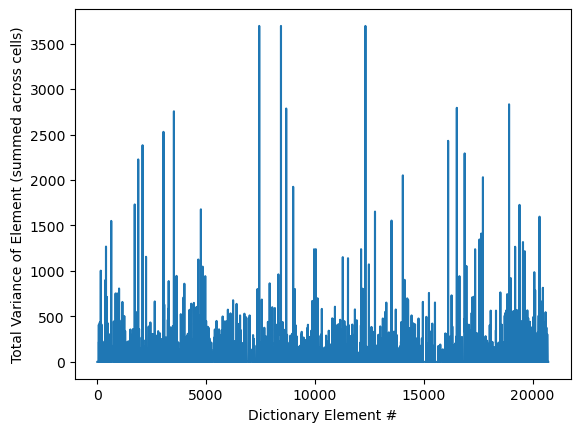

In [8]:
plt.plot(var_vec)
plt.xlabel('Dictionary Element #')
plt.ylabel('Total Variance of Element (summed across cells)')

In [ ]:
estim_dict = all_sigmoids.reshape([all_sigmoids.shape[0], all_sigmoids.shape[1]*all_sigmoids.shape[2]])
estim_dict[estim_dict < prob_low] = 0
good_elements = np.where((~np.isnan(np.sum(estim_dict, axis=0))) & 
                         (np.amax(estim_dict, axis=0) > prob_low))[0]

In [ ]:
estim_dict_pruned = np.hstack((estim_dict[:, good_elements], 
                               np.zeros(len(estim_dict)).reshape(-1, 1)))

In [ ]:
np.save(f'estim_dictionary_1elec_{dataset}', estim_dict_pruned)

In [ ]:
estim_dict_pruned.shape